In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
d = pd.read_csv("/Users/daron/Downloads/CTL Conversation Start Timestamps, 2015 and up, rounded down to nearest minute.csv - CTL Conversation Start Timestamps, 2015 and up, rounded down to nearest minute.csv.csv")

In [7]:
d.head()

,conv_start_est
0,2015-01-01 0:03:00
1,2015-01-01 0:07:00
2,2015-01-01 0:19:00
3,2015-01-01 0:24:00
4,2015-01-01 0:34:00


In [8]:
d.tail()

,conv_start_est
1119336,2017-08-27 3:18:00
1119337,2017-08-27 3:19:00
1119338,2017-08-27 3:19:00
1119339,2017-08-27 3:19:00
1119340,2017-08-27 3:20:00


In [9]:
d['ts'] = d['conv_start_est'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [10]:
d['month'] = d['ts'].apply(lambda x: x.month)

In [11]:
d['year'] = d['ts'].apply(lambda x: x.year)

In [12]:
d['dt'] = d['ts'].apply(lambda x: datetime(x.year, x.month, 1))

In [13]:
d['week_start'] = d['ts'].dt.to_period('W').apply(lambda r: r.start_time)

In [102]:
d['month_start'] = d['ts'].dt.to_period('M').apply(lambda r: r.start_time)

In [103]:
d.head()

,conv_start_est,ts,month,year,dt,week_start,month_start
0,2015-01-01 0:03:00,2015-01-01 00:03:00,1,2015,2015-01-01,2014-12-29,2015-01-01
1,2015-01-01 0:07:00,2015-01-01 00:07:00,1,2015,2015-01-01,2014-12-29,2015-01-01
2,2015-01-01 0:19:00,2015-01-01 00:19:00,1,2015,2015-01-01,2014-12-29,2015-01-01
3,2015-01-01 0:24:00,2015-01-01 00:24:00,1,2015,2015-01-01,2014-12-29,2015-01-01
4,2015-01-01 0:34:00,2015-01-01 00:34:00,1,2015,2015-01-01,2014-12-29,2015-01-01


In [94]:
totals.head()

,month,year,conv_start_est,ts,dt,week_start,seq
0,1,2015,7744,7744,7744,7744,0
3,2,2015,7626,7626,7626,7626,1
6,3,2015,9556,9556,9556,9556,2
9,4,2015,8923,8923,8923,8923,3
12,5,2015,14399,14399,14399,14399,4


In [104]:
totals = d.groupby('month_start').count().reset_index()

In [16]:
totals = totals.sort_values(['year', 'month'])

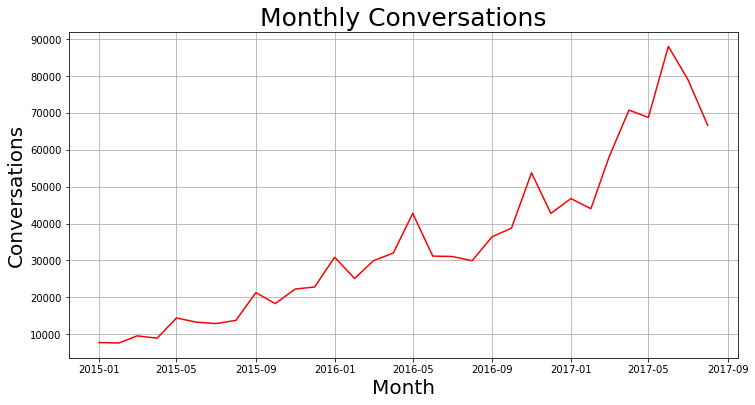

In [111]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(totals.month_start, totals.ts, color='red')
ax.set_xlabel('Month', size=20)
ax.set_ylabel('Conversations', size=20)
ax.set_title('Monthly Conversations', size=25)
ax.grid(which='major')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'adj'

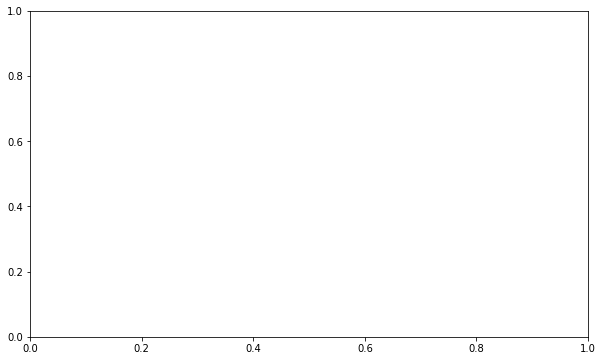

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
for x in totals.year.unique():
    df = totals[totals['year'] == x]
    ax.plot(df.month, df.adj)
plt.show()

In [29]:
totals['seq'] = range(len(totals))

In [30]:
# tots = d.groupby('dt').count()
tots = d.groupby('week_start').count()

In [31]:
tots['flt'] = tots['conv_start_est'].astype(float)

In [32]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

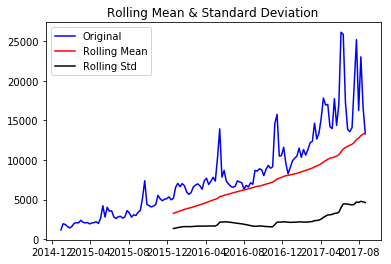

Results of Dickey-Fuller Test:
Test Statistic                   0.641584
p-value                          0.988597
#Lags Used                      11.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


In [33]:
test_stationarity(tots['flt'])

In [34]:
tots['lg'] = np.log(tots['flt'])

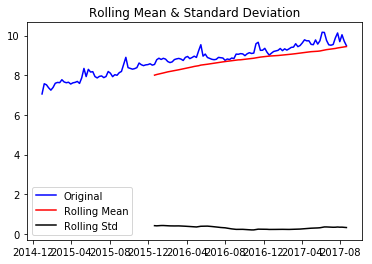

Results of Dickey-Fuller Test:
Test Statistic                  -1.502088
p-value                          0.532478
#Lags Used                       6.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


In [35]:
test_stationarity(tots['lg'])

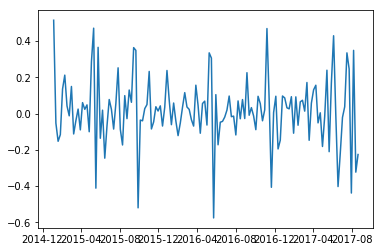

In [36]:
tots['diff'] = tots['lg'] - tots['lg'].shift()
plt.plot(tots['diff'])

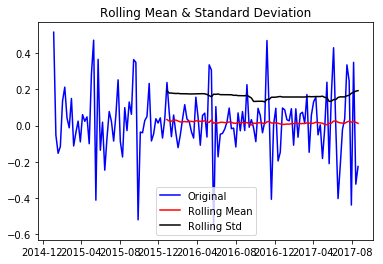

Results of Dickey-Fuller Test:
Test Statistic                -8.002974e+00
p-value                        2.307368e-12
#Lags Used                     5.000000e+00
Number of Observations Used    1.320000e+02
Critical Value (1%)           -3.480888e+00
Critical Value (5%)           -2.883697e+00
Critical Value (10%)          -2.578586e+00
dtype: float64


In [37]:
tots['diff'].dropna(inplace=True)
test_stationarity(tots['diff'])

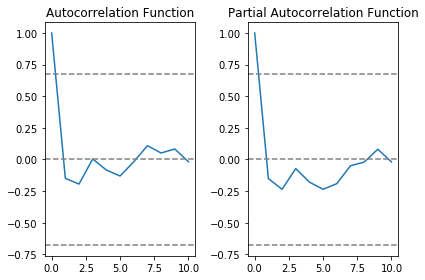

In [38]:
#ACF and PACF plots

lag_acf = acf(tots['diff'], nlags=10)
lag_pacf = pacf(tots['diff'], nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(tots['diff'])),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(tots['diff'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(tots['diff'])),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(tots['diff'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

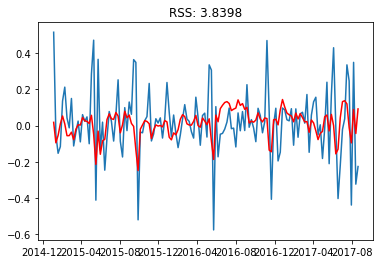

In [39]:
model = ARIMA(tots['lg'], order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(tots['diff'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-tots['diff'])**2))

                             ARIMA Model Results                              
Dep. Variable:                   D.lg   No. Observations:                  138
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  51.830
Method:                       css-mle   S.D. of innovations              0.166
Date:                Wed, 30 Aug 2017   AIC                            -95.660
Time:                        11:34:35   BIC                            -83.951
Sample:                    01-05-2015   HQIC                           -90.902
                         - 08-21-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0177      0.003      6.350      0.000       0.012       0.023
ar.L1.D.lg     0.5321      0.097      5.494      0.000       0.342       0.722
ma.L1.D.lg    -0.9145      0.047    -19.392      0.0

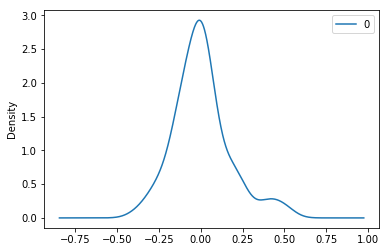

In [40]:
print(results_ARIMA.summary())
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [41]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

week_start
2015-01-05    0.017708
2015-01-12   -0.095359
2015-01-19   -0.053909
2015-01-26    0.008995
2015-02-02    0.052653
dtype: float64


In [42]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = tots['lg']
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

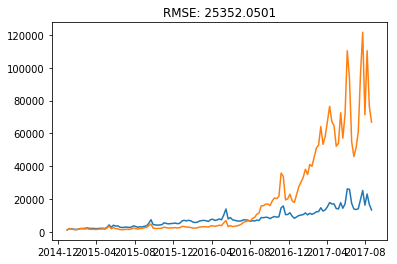

In [43]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(tots['flt'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-tots['flt'])**2)/len(tots['flt'])))

In [92]:
size = int(len(tots['lg']) - 15)
train, test = tots['lg'][0:size], tots['lg'][size:len(tots['lg'])]
history = [x for x in train]
predictions = list()

for q in range(18):
    test[datetime.strftime(date(2017,8,21)+timedelta(days=7*(q+1)), '%Y-%m-%d %H:%M:%S')] = 9+q*.1

print('Printing Predicted vs Expected Values...')
print('\n')
for t, ix in enumerate(range(len(test))):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    if ix < 15:
        history.append(obs)
        
    else:
        history.append(float(yhat))
        print(yhat)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=14819.548939, expected=17750.000000
predicted=17379.398804, expected=14382.000000
predicted=15318.275074, expected=17030.000000
predicted=17119.405409, expected=26160.000000
predicted=22811.626553, expected=25891.000000
predicted=23335.761863, expected=17306.000000
predicted=18246.494010, expected=13885.000000
predicted=15821.213035, expected=13593.000000
predicted=15468.098451, expected=14109.000000
predicted=15759.551368, expected=19719.000000
predicted=19624.147460, expected=25222.000000
predicted=23269.894985, expected=16266.000000
predicted=17802.231078, expected=23049.000000
predicted=22155.566760, expected=16681.000000
predicted=18388.212725, expected=13305.000000
[ 9.67455524]
predicted=15907.647345, expected=8103.083928
[ 9.77791621]
predicted=17639.856728, expected=8955.292703
[ 9.8412146]
predicted=18792.527542, expected=9897.129059
[ 9.88319612]
predicted=19598.261092, expected=10938.019208
[ 9.91383374]
predicted=20207.9

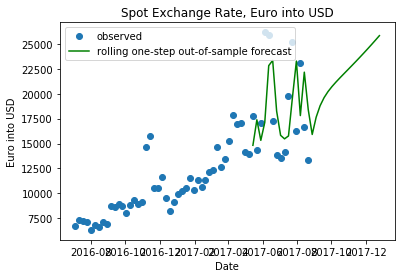

In [93]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(tots['flt'][-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [116]:
pd.DataFrame(np.exp(predictions_series))

,0
week_start,
2017-05-15 00:00:00,14819.548939
2017-05-22 00:00:00,17379.398804
2017-05-29 00:00:00,15318.275074
2017-06-05 00:00:00,17119.405409
2017-06-12 00:00:00,22811.626553
2017-06-19 00:00:00,23335.761863
2017-06-26 00:00:00,18246.494010
2017-07-03 00:00:00,15821.213035
2017-07-10 00:00:00,15468.098451


===

In [161]:
model = ARIMA(tots['flt'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.flt   No. Observations:                  138
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1233.043
Method:                       css-mle   S.D. of innovations           1827.704
Date:                Tue, 29 Aug 2017   AIC                           2480.086
Time:                        21:11:46   BIC                           2500.577
Sample:                    01-05-2015   HQIC                          2488.413
                         - 08-21-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         123.2450     54.242      2.272      0.025      16.933     229.557
ar.L1.D.flt    -0.3671      0.080     -4.591      0.000      -0.524      -0.210
ar.L2.D.flt    -0.4463      0.083     -5.371    

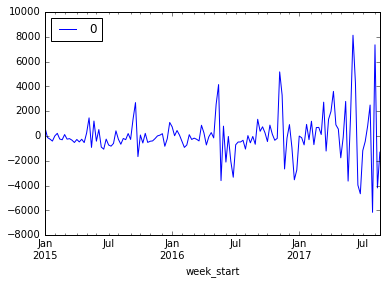

In [162]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

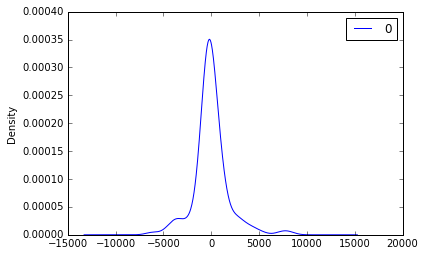

In [163]:
residuals.plot(kind='kde')

In [53]:
X = tots['flt']
size = int(len(X) * .9)
train, test = X[0:size], X[size:len(X)]
# test['2017-09-01'] = 60000
# test['2017-10-01'] = 70000
# test['2017-11-01'] = 80000
# test['2017-12-01'] = 90000
for q in range(17):
    test[datetime.strftime(date(2017,8,21)+timedelta(days=7*q+1), '%Y-%m-%d %H:%M:%S')] = 10000+q*500
history = [x for x in train]
predictions = list()
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=31)
for t in range(len(output[0])):
	yhat = output[0][t]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=17755.980670, expected=14382.000000
predicted=16994.000744, expected=17030.000000
predicted=17348.727771, expected=26160.000000
predicted=17363.594160, expected=25891.000000
predicted=16984.248632, expected=17306.000000
predicted=17363.331900, expected=13885.000000
predicted=17745.135392, expected=13593.000000
predicted=17767.134163, expected=14109.000000
predicted=17863.979993, expected=19719.000000
predicted=18044.570471, expected=25222.000000
predicted=18108.182151, expected=16266.000000
predicted=18201.770005, expected=23049.000000
predicted=18367.918608, expected=16681.000000
predicted=18500.821047, expected=13305.000000
predicted=18611.373055, expected=10000.000000
predicted=18743.836248, expected=10500.000000
predicted=18870.413518, expected=11000.000000
predicted=18986.018224, expected=11500.000000
predicted=19111.285390, expected=12000.000000
predicted=19240.089146, expected=12500.000000
predicted=19363.320433, expected=13000.000000
predicted=19487.443613, expected=1

In [114]:
pd.Series(predictions, index=test.index)

week_start
2017-05-15 00:00:00     9.603702
2017-05-22 00:00:00     9.763041
2017-05-29 00:00:00     9.636802
2017-06-05 00:00:00     9.747968
2017-06-12 00:00:00    10.035026
2017-06-19 00:00:00    10.057742
2017-06-26 00:00:00     9.811728
2017-07-03 00:00:00     9.669107
2017-07-10 00:00:00     9.646535
2017-07-17 00:00:00     9.665202
2017-07-24 00:00:00     9.884516
2017-07-31 00:00:00    10.054916
2017-08-07 00:00:00     9.787079
2017-08-14 00:00:00    10.005844
2017-08-21 00:00:00     9.819465
2017-08-28 00:00:00     9.674555
2017-09-04 00:00:00     9.777916
2017-09-11 00:00:00     9.841215
2017-09-18 00:00:00     9.883196
2017-09-25 00:00:00     9.913834
2017-10-02 00:00:00     9.938434
2017-10-09 00:00:00     9.959819
2017-10-16 00:00:00     9.979493
2017-10-23 00:00:00     9.998254
2017-10-30 00:00:00    10.016529
2017-11-06 00:00:00    10.034543
2017-11-13 00:00:00    10.052418
2017-11-20 00:00:00    10.070218
2017-11-27 00:00:00    10.087976
2017-12-04 00:00:00    10.105713